<a href="https://colab.research.google.com/github/yasinfahmy/Real-Estate-Price-Prediction/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Reading Data

Other things to keep in mind / research on:
*   Log Transformation
*   Standardization
*   weights and p-values of variables

Kata Notes:
* TODO: bind test and train datasets for cleaning to be in sync
* bind test and training datasets, assigning to each of them an indicator "train" or "test" to be able to split them later
* all_data = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
* Split the test and train datasets via the indicator
test1, train1 = all_data[all_data["ind"].eq("test")], all_data[all_data["ind"].eq("train")]
* TODO: (after data is clean and the first model is ready) split the train dataset into two df, to test the modal and adjust it before applying to test dataset
* TODO: change float types to integer types because linear regression is supported only on integer type variables. It can be converted using the ‘astype’ function in python.







In [199]:
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sklearn.model_selection as model_selection
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline 
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer 
from sklearn.feature_selection import SelectKBest, chi2 #limits number of features
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder #bin numerical variables
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 81)

In [200]:
train = pd.read_csv('https://raw.githubusercontent.com/Elnisa/nisa/main/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Elnisa/nisa/main/test.csv')

In [201]:
# Declaring Variables
y = train['SalePrice'] # Dependant variable
X = train.drop(['SalePrice', 'Id'], axis = 1) # Independant variables, excluding SalePrice and Id

In [202]:
# Splitting features into numerical and categorical
num_features = list(X.select_dtypes(exclude='object'))
cat_features = list(X.select_dtypes(include='object'))

# Data Exploration

In [203]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [229]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [204]:
# Data Types
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [ ]:
#Checking for missing values
missing_count = X.isna().sum()/len(X)*100
missing_count = missing_count[missing_count > 0]
missing_count.sort_values().shape

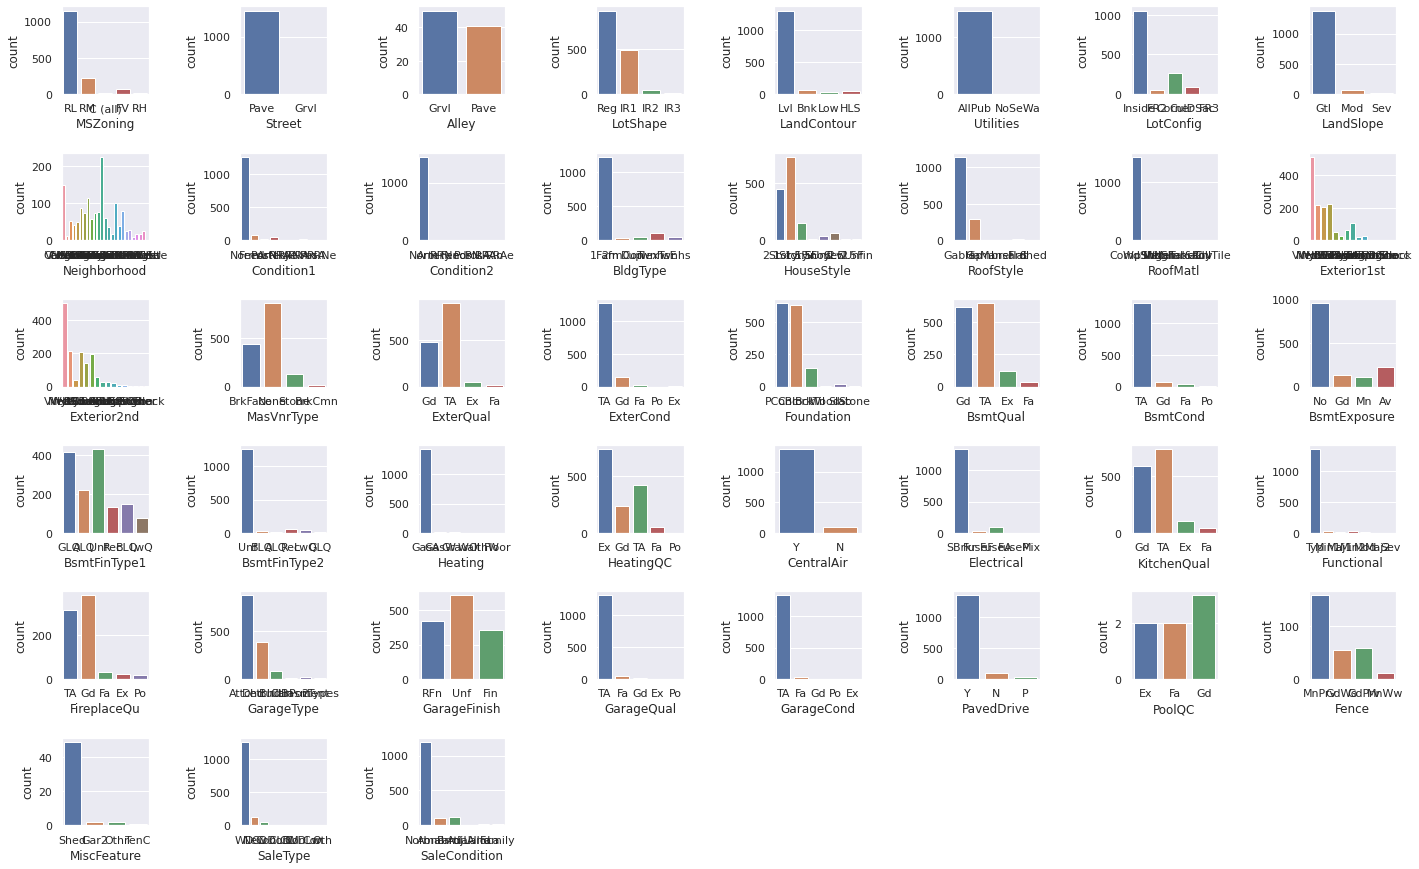

In [207]:
fig = plt.figure(figsize=(20,18))
for ind,col in enumerate(X[cat_features]):
    plt.subplot(9,8,ind+1);
    sns.countplot(x=X.loc[:,col],data=X[cat_features].dropna());

fig.tight_layout(pad=1.5);

In [208]:
# It is important that the categorical features have a high count and variance 
drop_cat = ['Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentrailAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
keep_cat = [col for col in cat_features if col not in drop_cat]

# Data Wrangling

## Handling Missing Value

### Imputing missing numerical values


In [276]:
#Checking for missing numerical values
missing_count_num = X[num_features].isna().sum()/len(X)*100
missing_count_num = missing_count_num[missing_count_num > 0]
missing_count_num.sort_values()

Series([], dtype: float64)

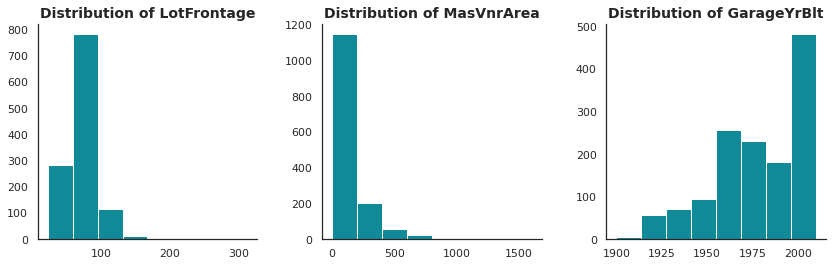

In [259]:
fig = plt.figure(figsize = (12, 4)) # determine the size of the figure for three sub plots

for idx,col in enumerate(missing_count_num.index):
  sns.set_style("white") # override the default matplotlib style, to avoid the grey background and grid
  plt.subplot(1,3,1+idx);
  plt.hist(X[col], # the variable on which to create the histogram
          bins = 8, # create a histogram with 8 bins
          color = "#108A99")
  plt.title("Distribution of "+col, fontsize = 14, weight = "bold")
  sns.despine() # removes the top and right border of our graph

fig.tight_layout(pad=1.5)
plt.show();

In [265]:
X['LotFrontage'] = X['LotFrontage'].fillna(abs(X['LotFrontage'].mean()))
X['MasVnrArea'] = X['MasVnrArea'].fillna(abs(X['MasVnrArea'].mean()))
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['GarageYrBlt'].mode()[0])
X[num_features].isna().sum().sum()

0

### Correctly impute missing categorical data

In [277]:
#Checking for missing categorical values
missing_count_cat = X[cat_features].isna().sum()/len(X)*100
missing_count_cat = missing_count_cat[missing_count_cat > 0]
missing_count_cat.sort_values()

Electrical       0.068493
MasVnrType       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtExposure     2.602740
BsmtFinType2     2.602740
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
FireplaceQu     47.260274
Fence           80.753425
Alley           93.767123
MiscFeature     96.301370
PoolQC          99.520548
dtype: float64

In [ ]:
# Drop columns with too many nan values
X['PoolQC'] = X['PoolQC'].fillna('No Pool')
X['MiscFeature'] = X['MiscFeature'].fillna('No miscellaneous features')
X['Alley'] = X['Alley'].fillna('No alley access')
X['Fence'] = X['Fence'].fillna('No fence')
X['FireplaceQu'] = X['FireplaceQu'].fillna('No fireplace')

X['GarageCond'] = X['GarageCond'].fillna('No garage')
X['GarageQual'] = X['GarageQual'].fillna('No garage')
X['GarageFinish'] = X['GarageFinish'].fillna('No garage')
X['GarageType'] = X['GarageType'].fillna('No garage')

X['BsmtFinType2'] = X['BsmtFinType2'].fillna('No basement')
X['BsmtExposure'] = X['BsmtExposure'].fillna('No basement')
X['BsmtFinType1'] = X['BsmtFinType1'].fillna('No basement')
X['BsmtCond'] = X['BsmtCond'].fillna('No basement')
X['BsmtQual'] = X['BsmtQual'].fillna('No basement')

X['MasVnrType'] = X['MasVnrType'].fillna('None')
X['Electrical'] = X['Electrical'].fillna('No information')

X[cat_features].isna().sum().sum()

# Pipelining Approach

In [209]:
# Splitting Training data into Train and Test Set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=21)

## Build Pipeline and Fit Model

In [210]:
# Imputations of numerical nan values with a pipeline
preprocessor = make_column_transformer( 
    (make_pipeline(
        KNNImputer(n_neighbors=15), # Imputing strategy k-nearest neighbours
        KBinsDiscretizer(n_bins=6), # binning numerical variables, making it easier for the algorithm 
        SelectKBest(chi2, k=15) # Select top 15 variables
        ), num_features), # take all numerical variables

    (make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value = 'missing'), # replaces nan values with 'missing'
        OneHotEncoder(categories = 'auto', handle_unknown = 'ignore') # Transform categrorical into dummy variables, the best ones will be selected # Any unknown vars in test set will be ignored
        ), cat_features)
)

In [211]:
model = make_pipeline(preprocessor, LinearRegression()) #Random forest regression?

In [212]:
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=15)),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=6)),
                                                                  ('selectkbest',
                                                                   SelectKBest(k=15,
                                                                               score_func=<function chi2 at 0x7f78de394950>))]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
      

## Model Accuracy

### Standard deviation of residuals / Root mean square error

In [213]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) #RMSE of saleprice real and predicted values in training set
y_test_pred_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)) #RMSE of saleprice real and predicted values in test set
print('Train RMSE: '+str(int(y_train_pred_rmse)))
print('Test RMSE: '+str(int(y_test_pred_rmse)))

Train RMSE: 23620
Test RMSE: 35515


### R-squared

In [214]:
print('Train R-squared: '+str(round(model.score(X_train, y_train), 3)))
print('Test R-squared: '+str(round(model.score(X_test, y_test), 3)))

Train R-squared: 0.91
Test R-squared: 0.814


### Adjusted R-squared

$R^2_{adj.} = 1 - (1-R^2)*\frac{n-1}{n-p-1}$

In [215]:
# R-squared
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_train, y_train)

# Number of observations
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Number of features
p_train = X_train.shape[1]
p_test = X_test.shape[1]

print('Train adjusted R-squared: '+str(round(1-(1-r2_train)*(n_train-1)/(n_train-p_train-1), 3)))
print('Test adjusted R-squared: '+str(round(1-(1-r2_test)*(n_test-1)/(n_test-p_test-1), 3)))

Train adjusted R-squared: 0.903
Test adjusted R-squared: 0.876


### Scatter plot

Text(0.5, 0, 'Targets (y_test)')

Text(0, 0.5, 'Predictions (y_test_pred)')

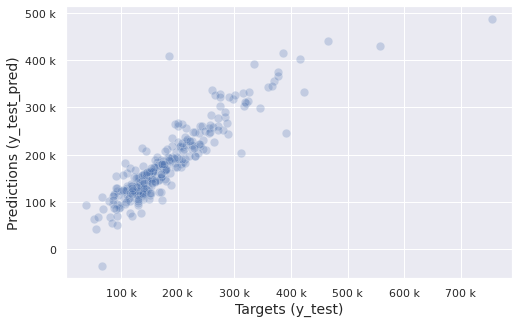

In [216]:
import matplotlib.ticker as ticker

# Scatter plot with the test targets and test predictions
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(ax=ax, x=y_test, y=y_test_pred, alpha=0.25, s=75)
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.xlabel('Targets (y_test)',size=14)
plt.ylabel('Predictions (y_test_pred)',size=14)
plt.show()

In [217]:
# Compare Predictions with targets, Error and %Difference in tabular form

# Data Exploration

## Feature Selection

### Numerical

Lets take a correlation of 0.5 as the cut off line. If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation. We will then get these numerical variables:

In [218]:
# Correlation of regressors to SalePrice only above 0.5 treshhold
saleprice_matrix = train[train.columns[1:]].corr()['SalePrice'][:-1].to_frame()
saleprice_matrix.loc[saleprice_matrix['SalePrice'] >= 0.5].sort_values('SalePrice', ascending=False).style.background_gradient(cmap="Blues")

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


* OverallQual 0.790982 (Rates the overall material and finish of the house)
* GrLivArea	0.708624 	(Above grade/ground living area square feet)
* GarageCars	0.640409	(Size of garage in car capacity)
* GarageArea	0.623431	(Size of garage in square feet)
* TotalBsmtSF	0.613581 	(Total square feet of basement area)
* 1stFlrSF	0.605852	(First Floor square feet)
* FullBath  0.560664  (Full bathrooms above grade)
* TotRmsAbvGrd	0.533723 (Total rooms above grade (does not include bathrooms)) 
* YearBuilt	0.522897 (Original construction date)
* YearRemodAdd	0.507101 (Remodel date (same as construction date if no remodeling or additions))
<br><br>
We can see that we have multicollinearity (Garagecars and GarageArea for example). Lets have another correlation matrix based on these filtered variables.


In [219]:
num_vars = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'SalePrice']
num_vars_matrix = train.loc[:, num_vars].iloc[1:]
num_vars_matrix.corr().style.background_gradient(cmap="Blues")

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
OverallQual,1.000000,0.592956,0.600639,0.561970,0.538131,0.476750,0.550445,0.427229,0.572153,0.550517,0.790974
GrLivArea,0.592956,1.000000,0.467206,0.468950,0.455039,0.566374,0.629975,0.825532,0.198828,0.287255,0.708599
GarageCars,0.600639,0.467206,1.000000,0.882467,0.434729,0.439596,0.469619,0.362209,0.537847,0.420560,0.640383
GarageArea,0.561970,0.468950,0.882467,1.000000,0.486832,0.490099,0.405570,0.337713,0.478903,0.371502,0.623400
TotalBsmtSF,0.538131,0.455039,0.434729,0.486832,1.000000,0.819516,0.324064,0.285962,0.391960,0.291440,0.613760
1stFlrSF,0.476750,0.566374,0.439596,0.490099,0.819516,1.000000,0.381231,0.410218,0.282725,0.240973,0.606197
FullBath,0.550445,0.629975,0.469619,0.405570,0.324064,0.381231,1.000000,0.554567,0.467979,0.438781,0.560619
TotRmsAbvGrd,0.427229,0.825532,0.362209,0.337713,0.285962,0.410218,0.554567,1.000000,0.094995,0.191296,0.533680
YearBuilt,0.572153,0.198828,0.537847,0.478903,0.391960,0.282725,0.467979,0.094995,1.000000,0.592603,0.522867
YearRemodAdd,0.550517,0.287255,0.420560,0.371502,0.291440,0.240973,0.438781,0.191296,0.592603,1.000000,0.507047


1) Garagecars and GarageArea have high correlation of 0.882467<br>
2) Basement and first floor Area have high correlation of 0.819516<br>
3) Living Area and number of rooms have high correlation of 0.825532<br>
4) Number of bathrooms and living area have a high correlation of 0.629975 <br>
5) Year build and remodel year have a high correlation of 0.592603 <br>
To avoid multicollinearity, lets consider dropping one of both variable-pairs. Lets have a look at the statistics.

In [220]:
train.loc[:, num_vars].describe()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,472.980137,1057.429452,1162.626712,1.565068,6.517808,1971.267808,1984.865753,180921.195890
std,1.382997,525.480383,0.747315,213.804841,438.705324,386.587738,0.550916,1.625393,30.202904,20.645407,79442.502883
min,1.000000,334.000000,0.000000,0.000000,0.000000,334.000000,0.000000,2.000000,1872.000000,1950.000000,34900.000000
25%,5.000000,1129.500000,1.000000,334.500000,795.750000,882.000000,1.000000,5.000000,1954.000000,1967.000000,129975.000000
50%,6.000000,1464.000000,2.000000,480.000000,991.500000,1087.000000,2.000000,6.000000,1973.000000,1994.000000,163000.000000
75%,7.000000,1776.750000,2.000000,576.000000,1298.250000,1391.250000,2.000000,7.000000,2000.000000,2004.000000,214000.000000
max,10.000000,5642.000000,4.000000,1418.000000,6110.000000,4692.000000,3.000000,14.000000,2010.000000,2010.000000,755000.000000


Pair comparison of both variables:<br>
1) Since garage area is a continous variable, with higher variance, it might be more suitable for regression. We can therefore drop GarageCars<br>
2) Since there are some real estate who do not have a basement, it makes more sense to take the first floor area variable as a regressor. We can therefore drop TotalBsmtSF<br>
3) Living area is also a continuous variable, unlike number of rooms above ground. Bathrooms are also not included, therefore Living  area is the preffered choice. <br>
4) For similar reasons, lets drop number of bathrooms as well. <br>
After dropping the irrelevant variables, lets have a again a look at the correlation matirx. For now these correlations are acceptable.
5) Year build has a higher variance, than YearRemodAdd

In [221]:
num_vars_final = ['OverallQual', 'GrLivArea', 'GarageArea', '1stFlrSF', 'YearBuilt', 'SalePrice']
num_vars_matrix2 = train.loc[:, num_vars_final].iloc[1:]
num_vars_matrix2.corr().style.background_gradient(cmap="Blues")

,OverallQual,GrLivArea,GarageArea,1stFlrSF,YearBuilt,SalePrice
OverallQual,1.000000,0.592956,0.561970,0.476750,0.572153,0.790974
GrLivArea,0.592956,1.000000,0.468950,0.566374,0.198828,0.708599
GarageArea,0.561970,0.468950,1.000000,0.490099,0.478903,0.623400
1stFlrSF,0.476750,0.566374,0.490099,1.000000,0.282725,0.606197
YearBuilt,0.572153,0.198828,0.478903,0.282725,1.000000,0.522867
SalePrice,0.790974,0.708599,0.623400,0.606197,0.522867,1.000000


### Categorical

A bar chart that plots the difference of max and min values of average sale price per categorical value for each variable. The higher the difference, the more significant it will be for this model.

In [222]:
var = np.array([])
diff = np.array([])

string_columns = list(train.select_dtypes(include='object'))

for col in string_columns:
  ds = train.groupby(col)['SalePrice'].mean().sort_values()
  var = np.append(var, col)
  diff = np.append(diff, ds.max()-ds.min())

#Create DataSeries and sort it
result = pd.Series(data=diff, index=var)
result = result.sort_values()

#Split DataSeries into two
x = pd.Series(result.index)
y = pd.Series(result.values)

<Figure size 576x576 with 0 Axes>

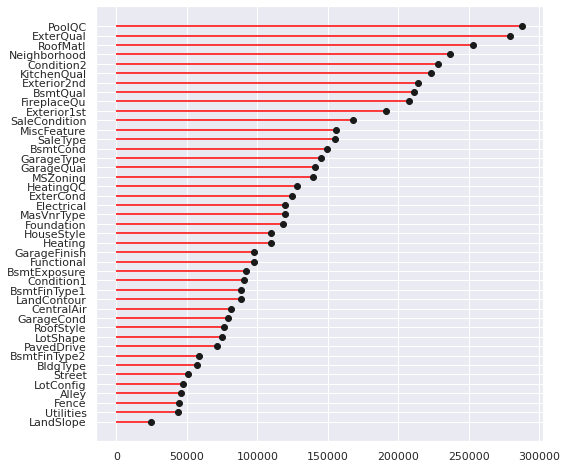

In [223]:
plt.figure(figsize=(8,8))
plt.hlines(y =x, xmin=0, xmax=y, color='red')
plt.plot(y, x, 'o', color='k')
plt.show()

Lets look at the top 10 Variables:<br>
* PoolQC (Pool quality)
* ExterQual (Evaluates the quality of the material on the exterior)
* 3SsnPorch (Three season porch area in square feet)
* RoofMatl (Roof material)
* Neighborhood (Physical locations within Ames city limits)
* Condition2 (Proximity to various conditions (if more than one is present))
* KitchenQual (Kitchen quality)
* BsmtQual (Evaluates the height of the basement)
* Exterior2nd (Exterior covering on house (if more than one material))
* FireplaceQu (Fireplace quality)


In [224]:
cat_top10 = ['PoolQC','ExterQual','3SsnPorch','RoofMatl','Neighborhood','Condition2','KitchenQual','BsmtQual','Exterior2nd','FireplaceQu']

**Plot against null values!!**

## Handling Missing Values

In [225]:
# % of NAs within each column of the original data set
missing_count = train.isna().sum()/len(train)*100
missing_count = missing_count[missing_count > 0]
missing_count.sort_values()

Electrical       0.068493
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtExposure     2.602740
BsmtFinType2     2.602740
GarageCond       5.547945
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
LotFrontage     17.739726
FireplaceQu     47.260274
Fence           80.753425
Alley           93.767123
MiscFeature     96.301370
PoolQC          99.520548
dtype: float64

In [226]:
remove_col = ['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

## Strings

In [227]:
# Define function that replaces nan values with appropriate value (i.e. no pool)

## Floats

In [228]:
# Fill in 0 values with a proper statistic
missing_count = train.select_dtypes(include='float64').isna().sum()/len(train)*100
missing_count = missing_count[missing_count > 0]
missing_count.sort_values()

MasVnrArea      0.547945
GarageYrBlt     5.547945
LotFrontage    17.739726
dtype: float64